# Task 2: Predictive Modeling – Booking Prediction

In [1]:
# Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from imblearn.combine import SMOTETomek

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# Load the dataset
df = pd.read_csv("../data/customer_booking.csv", encoding="ISO-8859-1")

In [3]:
# Encode flight day using mapping dictionary
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [4]:
# Encoding categorical columns
le = LabelEncoder()

df['sales_channel_encoded'] = le.fit_transform(df['sales_channel'])
df['trip_type_encoded'] = le.fit_transform(df['trip_type'])
df['route_encoded'] = le.fit_transform(df['route'])
df['booking_origin'] = le.fit_transform(df['booking_origin'])

In [5]:
# Define feature matrix and target variable
X = df.drop(columns=['sales_channel', 'trip_type', 'route', 'booking_origin', 'booking_complete'], axis = 1)
y = df['booking_complete']

In [6]:
# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Over sampling for minority class and cleaning borderline examples from the majority class
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

print(len(X_train))
print(len(X_resampled))

40000
66702


In [7]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

rf_model.fit(X_train, y_train)

rf_model.score(X_test, y_test)

0.8506

In [ ]:
# Get predicted probabilities for the positive class (class 1)
y_score_rf = rf_model.predict_proba(X_test)[:, 1]

In [100]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_score_rf)

In [101]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold (Max F1): {best_threshold:.3f}")

y_predict = (y_score_rf >= best_threshold).astype(int)


Best Threshold (Max F1): 0.200


In [102]:
# Evaluate the new predictions
print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[6630 1874]
 [ 686  810]]
              precision    recall  f1-score   support

           0       0.91      0.78      0.84      8504
           1       0.30      0.54      0.39      1496

    accuracy                           0.74     10000
   macro avg       0.60      0.66      0.61     10000
weighted avg       0.82      0.74      0.77     10000



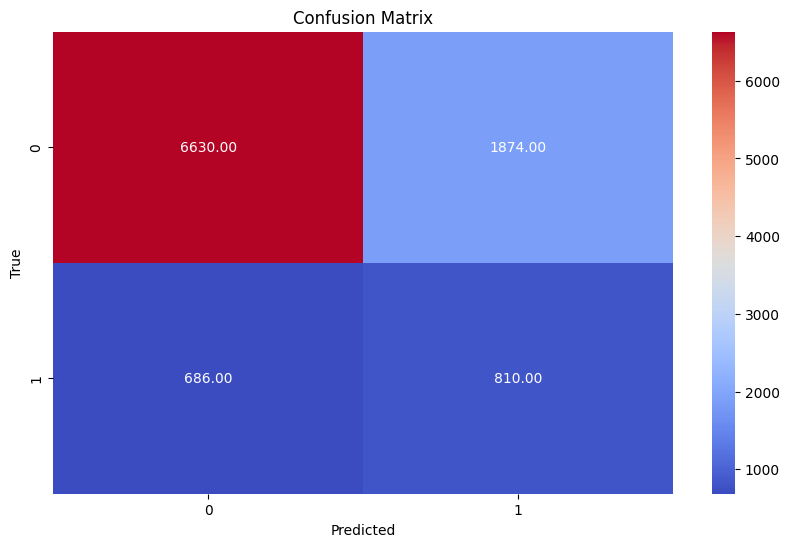

In [103]:
#Confusion matrix
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [104]:
# Calculate class imbalance ratio
neg, pos = np.bincount(y_train)
scale = neg / pos

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)

In [105]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [106]:
y_scores_xgb = model.predict_proba(X_test)[:, 1]

In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores_xgb)

In [108]:
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best Threshold (Max F1): {best_threshold:.3f}")

y_predict = (y_scores_xgb >= best_threshold).astype(int)

Best Threshold (Max F1): 0.529


In [109]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_predict))
print(classification_report(y_test, y_predict))

[[6281 2223]
 [ 551  945]]
              precision    recall  f1-score   support

           0       0.92      0.74      0.82      8504
           1       0.30      0.63      0.41      1496

    accuracy                           0.72     10000
   macro avg       0.61      0.69      0.61     10000
weighted avg       0.83      0.72      0.76     10000



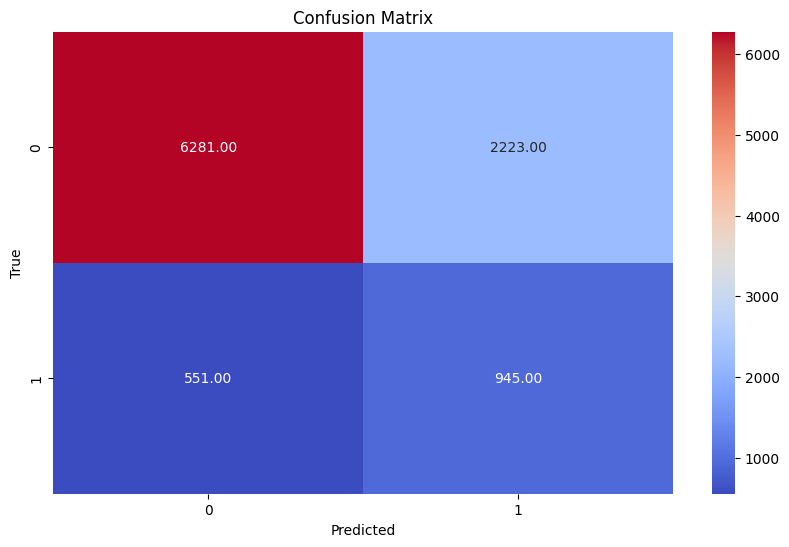

In [110]:
#Confusion matrix
cm = confusion_matrix(y_test, y_predict)

plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()